#ResNet50 Net Work Pipeline 

Purpose of this network is to determine phenotypes of our cell data. 


In [3]:
# import packages
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os
from tifffile import imsave

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage
%matplotlib inline
import scipy.ndimage as ndimage
import matplotlib.patches as mpatches
from scipy.stats import linregress
import scipy.stats
import scipy.signal
import scipy.spatial
import pandas as pd
import numpy as np
import math, re, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import linear_model
from datetime import datetime
from skimage import filters
import skimage, skimage.io, skimage.feature
from skimage.feature import register_translation
from skimage.filters import roberts, sobel, scharr, prewitt
#from skimage.feature.register_translation import _upsampled_dft

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

import glob
#from sklearn.datasets.samples_generator import make_blobs
from sklearn.mixture import GaussianMixture

from skimage.measure import label, regionprops

import time as Time
from skimage.morphology import remove_small_objects
from skimage.measure import find_contours
import scipy.ndimage as ndimage
from scipy import ndimage as ndi
import pylab
from skimage.segmentation import flood 
import cv2
import numpy as np
from statistics import stdev 

In [4]:
##### import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import helper
from PIL import Image, ImageDraw
from scipy import ndimage as ndi
from skimage.morphology import remove_small_objects
from skimage.color import rgba2rgb
from skimage import data
import os 
import tifffile as tiff
import torch.optim as optim
import torch.nn.functional as F
import copy
import tensorflow as tf
from skimage.filters import threshold_otsu

In [6]:
from google.colab import drive
drive.mount('/content/drive') # mounting google drive so I can access files and save files 
os.chdir('/content/drive/My Drive/') # changing Directories so that this is the default 

Mounted at /content/drive


In [7]:
import os

# define the name of the directory to be created
path = os.getcwd() + '/training_data'
path1= os.getcwd() + '/training_data/gfp'
path2 = os.getcwd() + '/training_data/rfp'
path3 = os.getcwd() + '/training_data/mask'
try:
    os.mkdir(path)
    os.mkdir(path1)
    os.mkdir(path2)
    os.mkdir(path3)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)


Creation of the directory /content/drive/My Drive/training_data failed


In [8]:
path = os.getcwd()+'/training_data/' 
os.chdir(path)
os.getcwd()

'/content/drive/My Drive/training_data'

In [ ]:
!wget http:/~michael/mix_40x40_gfp.tar.gz -P /drive/STRP
!mkdir /drive/STRP/mito/
!tar xvf /drive/STRP/mix_40x40_gfp.tar.gz -C /drive/STRP/mito

In [10]:
from sklearn.utils import shuffle
'this is making a dataframe that will house all the files and split it randomly into training and test dataset afterwards I can always load in the same training or testing dataset'

datainfo = 'mix_data' # for saving datafiles 
l = []
path1 = filepath = '/mix_40x40_gfp'
pattern = re.compile('.*cell_.*s(\d+)t(\d+)z(\d+)c(\d)_ORG.tif')
for file in os.listdir(path1):
    match = pattern.match(file)
    if match:
        cell = match.group(0).split('cell_')
        cell = cell[1].split('-')[0]
        cell = int(cell)
        #cell = int(match.group(1)) #which cell in that position
        pos = int(match.group(1)) #position
        frame = int(match.group(2)) #time
        z = int(match.group(3)) #which z
        channel = int(match.group(4)) #channel
    
    
        l.append({'cell':cell, 'pos': pos, 'time': frame, 'zstack': z,'channel':channel ,'file': file})
filedf = pd.DataFrame(l)
filedf = shuffle(filedf) # shuffle your data

# splitting dataframes
traindf = filedf.sample(frac = 1) # CHANGE! keeping 80% of the data
testdf = filedf.drop(traindf.index) # putting the other 20% in testing 

print('total dataset {}'.format(filedf.shape[0]))
print('traindf dataset samples {}'.format(traindf.shape[0]))
print('testdf dataset samples {}'.format(testdf.shape[0]))
print('testdf+traindf= {}'.format(testdf.shape[0]+traindf.shape[0]))

total dataset 11678
traindf dataset samples 11678
testdf dataset samples 0
testdf+traindf= 11678


# saving training and Testing Df so we can reuse it. 
datainfo = 'mix_data' 
traindf.to_csv(os.getcwd()+'/'+'train_dataset_{}.csv'.format(datainfo), sep = '\t' , index = True) # index true saves without index so 'unamed:0'
testdf.to_csv(os.getcwd()+'/'+'test_dataset_{}.csv'.format(datainfo), sep = '\t', index = True ) 
filedf .to_csv(os.getcwd()+'/'+'all_dataset_{}.csv'.format(datainfo), sep = '\t' , index = True)  

In [ ]:
traindf.drop(traindf.reset_index().set_index('file').loc[(testdf['file'].values)]['index'].values, inplace=True)   

In [ ]:
os.getcwd()

'/content/drive/My Drive/training_data'

In [11]:
## load the Dataframes for Testing and train
datainfo = 'mix_data' 
traindf = pd.read_csv(os.getcwd()+'/'+'train_dataset_{}.csv'.format(datainfo), sep = '\t', index_col=0) # index_col loads it in with the index shuffled as is 
testdf =pd.read_csv(os.getcwd()+'/'+'test_dataset_{}.csv'.format(datainfo), sep = '\t', index_col=0)
filedf =pd.read_csv(os.getcwd()+'/'+'all_dataset_{}.csv'.format(datainfo), sep = '\t', index_col=0)
#rlsdf = pd.read_csv(os.getcwd()+'/'+'Mitochondria_COX4_daughter_cells.csv', sep = '\t', index_col=0)
#rlsdf = rlsdf.set_index('position')

print('total dataset {}'.format(filedf.shape[0]))
print('traindf dataset samples {}'.format(traindf.shape[0]))
print('testdf dataset samples {}'.format(testdf.shape[0]))
print('testdf+traindf= {}'.format(testdf.shape[0]+traindf.shape[0]))

total dataset 11678
traindf dataset samples 10713
testdf dataset samples 965
testdf+traindf= 11678


In [12]:
expvaldf_average= None

In [13]:
def loaddata(df, filepath, threshold = True, resize = (224,224), norm2 = None):
    """ enter in a dataframe with the filename and filepath will be read in 
    the file will then be resized default is 40X40 and normalized from 0-1 if it is not done already
    you then have an option to peform a threshold
    df - dataframe wtih a column that has the actual filename
    filepath- the folder where to find the files
    threshold - default is True will create a mask of the channel using the mean threshold and .2*std over 
    resize = if you want to make the images a specific size """
    image_stack = np.zeros((df.shape[0], resize[0], resize[1])) 
    mask_stack= np.zeros((df.shape[0],1, 1))  
    for row in list(range(0,df.shape[0])):
        file = df.iloc[[row]]['file'].values[0] # getting the file from the dataframe 
    
        image = skimage.io.imread(filepath+ '/'+ file) #Image.open(img_name) # open the image using the path
        if image.shape != resize: # resizing the image to whatever 
            image = cv2.resize(image, resize) 
        
        # if the image is not normalzie it will be normalzied 
        #if (image.min() != 0)  or (image.max() != 1):
        image = (image - np.min(image))/ (np.max(image)- np.min(image))# normalize it to 0-1

        if norm2 is not None:
            experiment = file.split('_s')[0]
            experiment = experiment.split('-')[-1]
            meanexperi = norm2.set_index('experiment').loc[experiment,'mean']
            stdexperi = norm2.set_index('experiment').loc[experiment,'std']
            overallmax = np.max(norm2['max'])
            overallmean = np.mean(norm2['mean'])

            image = (image- meanexperi )/stdexperi
            #image = (image- overallmean )/np.mean(norm2['std'])
            #image = image / overallmean 
            image = image/np.max(image)
            image[image<0] = 0
            #transformx = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor(), transforms.Normalize((0.5),(0.5))])
            #image = transformx(image.astype(np.float32))
            #image = image.to('cpu').detach().numpy()
            #image = ((image * .5) + .5)

 

        image = image.astype(np.float32) # musthave as float so that tensorflow views it as a float not double or numpy array

        # peforming thresholding
            # threshold is done after normalization 
        thresh = np.mean(image) +(np.std(image)*.2)
        mask = image >= thresh
        if threshold is True:
          image[~mask] = 0 # just turn everything else to 0 but leave the high intesnity values the same 
          #image[mask] = 1  


        # assigning the phenotype 
        if 'circle_' in file:
            mask = 0
        elif 'senecent_' in file:
            mask = 1
        elif 'cytoplasm_' in file:
            mask = 2
        elif 'nuclear_' in file:
            mask = 3
        elif 'fragmented_' in file:
            mask = 4  
        elif 'BinaryAggregate_' in file:
          mask = 5
        elif 'triple_' in file:
            mask = 6
        
        image_stack[row,:,:] = image
        mask_stack[row,:,:] =   int(mask)
        # for transformations 
        
    #image =  transform(image) # apply any transforms to turn to tensor flow 
    #image_stack = tf.convert_to_tensor(image_stack, np.float32)
 

    return [image_stack, mask_stack]


In [14]:
from itertools import repeat
import random 
import torchvision.transforms.functional as TF
import torchvision.transforms as T
from skimage.filters import unsharp_mask
import skimage.draw
import torch
from PIL import Image 

def varmean_data(filedf, allimg):
    ''' used to calculate the mean and std of each experimental batch 
    filedf dataframe with the files,
     allimg is a numpy array with the files loaded in '''
    l = []
    for row in list(range(0,filedf.shape[0])):
            file = filedf.iloc[[row]]['file'].values[0] 
            experiment = file.split('_s')[0]
            experiment = experiment.split('-')[-1]
            mean = np.mean(allimg[row,:,:])
            minval = np.min(allimg[row,:,:])
            maxval = np.max(allimg[row,:,:])
            std = np.std(allimg[row,:,:])
            l.append({'index': row, 'experiment': experiment, 'file': file, 'mean': mean, 'std': std, 'min': minval, 'max': maxval})
    expvaldf = pd.DataFrame(l)


    group = expvaldf.groupby('experiment')
    l = []
    for experiment in expvaldf['experiment'].unique():
        newmean = group.get_group(experiment)['mean'].mean()
        newstd = group.get_group(experiment)['std'].mean()
        newmin = group.get_group(experiment)['min'].mean()
        newmax = group.get_group(experiment)['max'].mean()
        l.append({'experiment': experiment, 'mean': newmean, 'std': newstd, 'min': newmin, 'max': newmax})
    expvaldf_average = pd.DataFrame(l)
    return [expvaldf, expvaldf_average]



if expvaldf_average is None:
  allimg, poo = loaddata(filedf, path1, path2 ) 
  expvaldf, expvaldf_average = varmean_data(filedf, allimg)

def cv2_clipped_zoom(img, zoom_factor=0):

    """
    Center zoom in/out of the given image and returning an enlarged/shrinked view of 
    the image without changing dimensions
    ------
    Args:
        img : ndarray
            Image array
        zoom_factor : float
            amount of zoom as a ratio [0 to Inf). Default 0.
    ------
    Returns:
        result: ndarray
           numpy ndarray of the same shape of the input img zoomed by the specified factor.          
    """
    if zoom_factor == 0:
        return img


    height, width = img.shape[:2] # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)
    
    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]
    
    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)
    
    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result
 

class imageDataGenerator(Dataset):
  def __init__(self, img_dir= path1, annotation_dir=path2, norm2 = expvaldf_average, transformme = True):
     
    self.img_dir = img_dir # what directory are the images in
    #self.annotation_dir = annotation_dir # what directory are the annotations in
 

    self.img_names = set(df['file'].values) # will be a dataframe that is for train and test files to load.
    self.img_names = [os.path.join(img_dir, img_name) for img_name in self.img_names] # join folder and file names

    #self.annotation_names = set(df['file'].values) # list all annotation files
    #self.annotation_names = [os.path.join(annotation_dir, ann_name) for ann_name in self.annotation_names] # join folder and file names

    #self.transform = transform
    self.transformme = transformme # to be used for the transform function
 


  def transform(self, image, mask, resizex = 224, resizey = 224):

      if image.shape != (resizex, resizey):
        image = cv2.resize(image, (resizex, resizey)).astype(np.float32) 

      if self.transformme is True:
        # turn to pil image so function can run 
        # thresholding
        decision = [True, False]
        if random.choice(decision) is True:
          thresh = np.mean(image) +(np.std(image)*.2)
          maskgfp = image >= thresh
          image[~maskgfp] = 0 # just turn everything else to 0 but leave the high intesnity values the same 
          #if random.random() < 0.25: # turn to binary randomly 
          #image[maskgfp] = 1 # to turn data mostly to binary 

        #shuffling data
        #if random.random() < 0.25:
        # maskgfp = image> (np.mean(image) + (np.std(image))) # strong threshold so we retain some structure but shuffle high intensity values 
          #arr = image[maskgfp]
          #np.random.shuffle(arr)
          #arr = ndi.gaussian_filter(arr, sigma = 1) # by bluring a smaller region after shuffling to make the picture more real
          #image[maskgfp] = arr

        # random Erasing making random shapes and fill in the picture to zero 
        #if random.random() < 0.25:
        # box, labels = skimage.draw.random_shapes((resizex, resizey), max_shapes=1, min_size=5, max_size = 10) # change shape size 
          #maskerase = box[:,:,1] < np.mean(box[:,:,1])  # gives three channels we just need one, get mean over and we get a random shape as a mask
          #if random.random() > .5: # replace the shape region with zero
          # image[maskerase] = 0 
          #else:  # replace the shape region with random variables in the image
          #  image2 = image.copy()
          # np.random.shuffle(image2)
            #image[maskerase] = image2[maskerase]

        # resizing 
        if random.random() > 0.5:
          if random.random() < 0.25:
            image = cv2.resize(image , (20, 20)) # downsample the image by half
            image = cv2.resize(image, (resizex, resizey)).astype(np.float32) # upscale the image back to 40,40 keeps the original shape by will distort the actual intensities 

          #if random.random() > 0.5:
          #  factor = random.uniform(.8, 1.2) # select a random variable between .6 to 1.3
          # image = cv2_clipped_zoom(image, zoom_factor=factor).astype(np.float32)

        # convering to pill this way we can turn it to a tensor 
        image = TF.to_pil_image(image)
        mask =mask

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)

        # random rotations 
        if random.random() > 0.5:
          rotations = [0,45,90,135,180,270]
          angle = random.choice(rotations)
          image = TF.rotate(image, angle)

        #Gaussian Blur
        if random.random() > 0.6:
          image= ndi.gaussian_filter(image, sigma = 1)
          image = TF.to_pil_image(image)

      #Randome Gaussian Noise -- only for images
        if random.random() < 0.20:
            factor_param = random.uniform(0.01, 0.5)
            std = np.std(image)
            image = image + factor_param * std * np.random.randn(resizex,resizey) # change this size to the size of the image

          # Unsharp filter -- only for images
        if random.random() < 0.25:
            radius_param = random.uniform(0, 1)
            amount_param = random.uniform(0.5, 1)
            image = unsharp_mask(image, radius = radius_param, amount=amount_param)

        # random translation 
        if random.random() > 0.5:
          fills = ['mirror','constant','wrap', 'reflect' ]
          fill = random.choice(fills)
          numbs = range(-40,40)
          numb1 = random.choice(numbs )
          numb2 = random.choice(numbs)
          image = scipy.ndimage.shift(image, [numb1,numb2 ], mode= fill)



        # Transform to tensor
        #image[np.isnan(image)] = 0
  
        if (np.min(image) != 0)  or (np.max(image) != 1): # in case augmenttion changed the normalization set back to 0 -1 
          image = (image - np.min(image))/ (np.max(image)- np.min(image))# 

          # to turn data mostly to binary 
          #maskgfp = image >  np.mean(image) +(np.std(image)*.2)
          #image[~maskgfp] = 0
          #image[maskgfp] = 1
      else:
        if (np.min(image) != 0)  or (np.max(image) != 1): # in case resizing changed the normalization set back to 0 -1 
          image = (image - np.min(image))/ (np.max(image)- np.min(image))
      # Train or validation will be turned to tensorflow
      image = TF.to_tensor(image)


       
 
      #mask = TF.to_tensor(mask)
      return image, mask
  
  def __getitem__(self, idx, norm2 = expvaldf_average):
      """ this will increase your dataset by rotating, flipping, and adding noise 
      will increase your dataset 7 times! 
      rotating 45, 90, 135, 224, 270 degrees
      will return a numpy array to a tensorflow """
       
      img_name = self.img_names[idx] # get the path of the image at that index
      #ann_name = self.annotation_names[idx]

      image =skimage.io.imread(img_name) # open the image using the path
      
      # assigning the phenotype 
      file = img_name
      if 'circle_' in file:
          mask = 0
      elif 'senecent_' in file:
          mask = 1
      elif 'cytoplasm_' in file:
          mask = 2
      elif 'nuclear_' in file:
          mask = 3
      elif 'fragmented_' in file:
          mask = 4
      elif 'BinaryAggregate_' in file:
        mask = 5
      elif 'triple_' in file:
          mask = 6
 
 
      
      # if the image is not normalzie it will be normalzied 
      if (image.min() != 0)  or (image.max() != 1):
        image = (image - np.min(image))/ (np.max(image)- np.min(image)) # normalize it to 0-1

      #if random.random() < 0.25: #norm2 is not None: # to normalize the image however, doesn't work well after agumentation and renormalizing back to 0-1
       # file = img_name.split('/')[-1]
        #experiment = file.split('_s')[0]
        #experiment = experiment.split('-')[-1]
        #meanexperi = norm2.set_index('experiment').loc[experiment,'mean']
        #stdexperi = norm2.set_index('experiment').loc[experiment,'std']

        #image = (image- meanexperi )/stdexperi
        #image = image / np.max(image)
        #image[image<0] = 0

      image = image.astype(np.float32) # musthave as float so that tensorflow views it as a float not double or numpy array


      image, mask = self.transform(image, mask)
      
      #if image.shape != resize: # resizing the image to whatever 
        #image = cv2.resize(image, resize) 
        #image = tensor.resize_(resize)

      #if self.transform: # if any transforms were given to initialiser
        #image = torch.from_numpy(image).long()
        #mask = torch.from_numpy(mask).long()
        #image =transforms.ToPILImage(image)
        #mask = transforms.ToPILImage(mask)
        #image = self.transform(image) # apply any transforms
        #mask= self.transform(mask) # apply any transforms
      
 
    

      return [image, mask]
  def __len__(self):
    return len(self.img_names) # length of the image dicationary 




### Checking Experimental Data
despite normalizations we could still see differences in the images taken from different experiments. 
If the differences between the mean and variance are apparent we will need to do a batch normalization during training or peform a different normalization!

In [15]:
allimg, dump = loaddata(filedf, path1, path2 ) 
expvaldf, expvaldf_average = varmean_data(filedf, allimg)


In [16]:
allimg, dump = loaddata(filedf, path1, path2 , norm2 =  expvaldf_average) 
del dump
expvaldf2, expvaldf_average2 = varmean_data(filedf, allimg)

Text(0.5, 1.0, 'Average Mean and Std of Images in Experiment After Full Normalization')

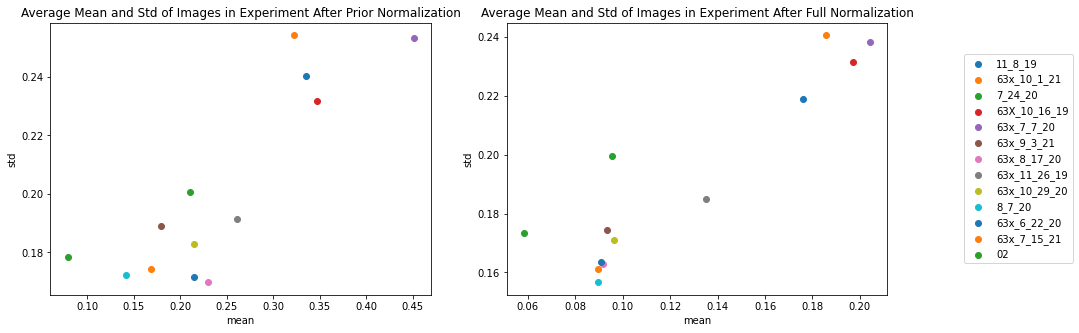

In [17]:
import seaborn as sns
" To observe the variation between experiments, although there seems to be variation I found that removing it harmed the input images"
f, ( ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
 
for i in expvaldf_average.index:
    ax1.scatter(expvaldf_average.iloc[i]['mean'],expvaldf_average.iloc[i]['std'])
#ax1.legend(expvaldf_average['experiment'], loc = 'right', bbox_to_anchor=(.7, 0., 0.5, 1))

ax1.set_xlabel('mean')
ax1.set_ylabel('std')
ax1.set_title('Average Mean and Std of Images in Experiment After Prior Normalization')


for i in expvaldf_average2.index:
    ax2.scatter(expvaldf_average2.iloc[i]['mean'],expvaldf_average2.iloc[i]['std'])
ax2.legend(expvaldf_average2['experiment'], loc = 'right', bbox_to_anchor=(1, 0., 0.5, 1))

ax2.set_xlabel('mean')
ax2.set_ylabel('std')
ax2.set_title('Average Mean and Std of Images in Experiment After Full Normalization')


#sns.lmplot('mean', 'std', data=expvaldf, hue='experiment', fit_reg=False)
#plt.show()
#plt.tight_layout()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


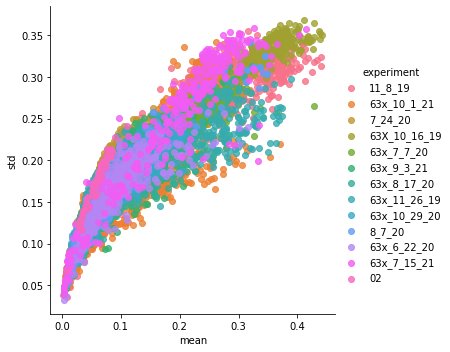

<Figure size 432x288 with 0 Axes>

In [18]:
sns.lmplot('mean', 'std', data=expvaldf2, hue='experiment', fit_reg=False)
plt.show()
plt.tight_layout()

##Making the Training Data 

In [19]:
# loading in your dataset from the DataFrame
#train_set, mask_stack1 = loaddata(traindf,path1,path2 ) # default turns images to 40X40 unless resize is changed 
df = traindf 
train_dataset =imageDataGenerator(img_dir= path1, annotation_dir=path2, norm2 = expvaldf_average, transformme = True) # increasing dataset 8 fold

del df

#val_set, mask_stack2  = loaddata(testdf,path1,path2 )
df = testdf
test_dataset =imageDataGenerator(img_dir= path1, annotation_dir=path2, norm2 = expvaldf_average, transformme = False) # valdation dataset WITHOUT augmentation
del df

batch_size =32 #dividng your whole data in batches 
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
}

# for MixUP 
#dataloaders2 = {
 #   'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
  #  'val': DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
#}

# seperating the dataset
#train_loader2 = dataloaders2['train'] 
#test_loader2 = dataloaders2['val'] 
 
# seperating the dataset
train_loader = dataloaders['train'] 
test_loader = dataloaders['val'] 

torch.Size([32, 1, 224, 224]) torch.Size([32])
label tensor(3)
max 1.0 min 0.0


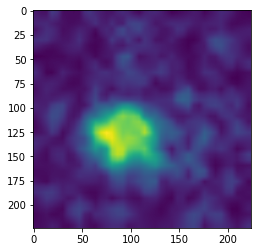

In [ ]:
# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
#f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,10))
plt.imshow(inputs[0][0] )
print('label', masks[0])
#ax1.imshow(inputs[0][0])
#ax2.imshow(masks[0][0])

# grab a batch from the train loader
batch, classes = next(iter(train_loader))
batch.shape
print('max {}'.format(inputs[0][0].max()), 'min {}'.format(inputs[0][0].min()))

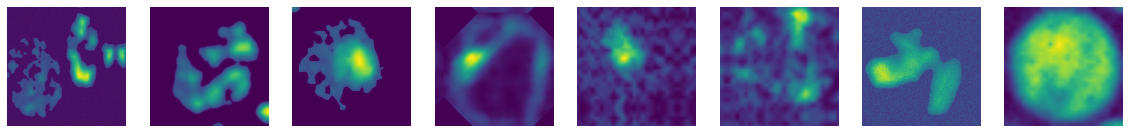

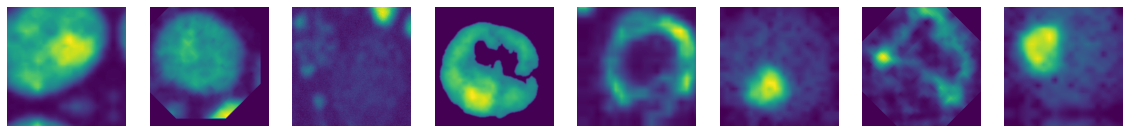

In [ ]:
# compare train_dataset 
    # this should have the image augmented datasets 
fig,ax = plt.subplots(1,8,figsize=(20,20))
for i in range(8):
    ax[i].imshow(train_dataset[i][0].reshape(inputs.shape[-2:]))
    ax[i].axis('off')
    
fig,ax = plt.subplots(1,8,figsize=(20,20))
for i in range(8):
    ax[i].imshow(train_dataset[i+8][0].reshape(inputs.shape[-2:]))
    ax[i].axis('off')

## RESNET50 

In [20]:
import torch
import torch.nn as nn
import numpy as np 
import torchvision.transforms as transforms 
import torchvision 
import torch.nn.functional as F
from torchsummary import summary
'The ResNet50 code and implementation can be found from these three sources. The only change I did to the original code was change the number of channels used'
#https://www.youtube.com/watch?v=DkNIBBBvcPs
#https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/CNN_architectures/pytorch_resnet.py
#https://cv-tricks.com/keras/understand-implement-resnets/
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1): # identity_downsample this is to deal with the changing of conv layers when we skip 
        super(block, self).__init__()
        self.expansion = 4 # number of channels after a block is always 4 times that of what it entered so 64, 128, 256, 512. so if we go to 64 to 256 its 4X and vice versa for 128 to 512
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(intermediate_channels,intermediate_channels,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(intermediate_channels,intermediate_channels * self.expansion, kernel_size=1,stride=1, padding=0,bias=False)
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample # used for if it is the same shape in the layers
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module): # how many times we want to reuse the block so resnet50 is [3,4,6,3]
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer( block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer( block, layers[3], intermediate_channels=512, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels,intermediate_channels * 4,kernel_size=1,stride=stride,bias=False),nn.BatchNorm2d(intermediate_channels * 4),)
        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

def ResNet50(img_channel=1, num_classes=7): # change channels and number of classes used
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)

def ResNet101(img_channel=1, num_classes=7): # change channels and number of classes used
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


model = ResNet50() # calling the model

In [21]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device('cpu')

print('device used {}'.format(device))

device used cuda


In [22]:
 import time

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.to(device)

    train_loss, valid_loss = [], []

    best_acc = 0.0
  
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                # normalizing by the batch 
                #x -= x.min() # bring the lower range to 0
                #x /= x.max() # bring the upper range to 1
                
                x = x.to(device).float() # to avoid the stupid double tensor problem 
                y = y.to(device).float()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)#.type(torch.torch.long)
                    loss = loss_fn(outputs , y.long() )  

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long()) 

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)
  
                

                running_acc  += acc *dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 10 == 0:
                  #clear_output(wait=True)
                  print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                  #print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc =  running_acc / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.to(device)).float().mean()

In [ ]:
# loading a pretrained model
# the purpose is to use a pretrained model, this model was trained on the 1million ImageNet data 

premodel = models.resnet50(pretrained = True)
num_ftrs = model.fc.in_features  # want to exchange the last fully connected layers 

# create a new layer
premodel.fc = nn.Linear(num_ftrs, 7)
premodel.to(device) 

#freeze layers and train

#for param in premodel.parameters():
 # param.requires_grad = False # this will freeze all the layers in the begining so you can train only the last linear model


# chanbge its inputs
#premodel = resnet50()
#premodel.conv1.in_channels = 9

In [ ]:
# using a pretrained model 
#https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/2
#https://discuss.pytorch.org/t/how-to-assign-an-arbitrary-tensor-to-models-parameter/44082/2
replace = True
freeze = True
# creating a dictionary from pretrained model to hold the weights 
dic ={}
for name, param in premodel.named_parameters():
  dic[name] = param

# getting mean of all the weights from 3 channels to 1
premodel = models.resnet50(num_classes=1000, pretrained=True)
archlist = list(premodel.children())
w = archlist[0].weight
archlist[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=2, bias=False) # turn this into one channel so now it is from [64,3,7,7] to [64, 1,7,7]
archlist[0].weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))
archlist= nn.Sequential(*archlist)
dic['conv1.weight'] = nn.Parameter(torch.mean(w, dim=1, keepdim=True)) # turn this into one channel so now it is from [64,3,7,7] to [64, 1,7,7]
#replacing the weights of our resnet50 model with a pretrained model
if replace is True:
  with torch.no_grad():
      for name, param in model.named_parameters():
          if 'fc' not in name: # fc is the last linear layer which we will keep as our phenotypes 7
            if name in dic.keys():
                param.copy_(dic[name])

# freezing the model except for the FC layer. 
if freeze is True:
  ct = 0
  for child in model.children():
    ct += 1
    if ct < 8: #1-7 in the total 10 layers of Resnet50
        for param in child.parameters():
            param.requires_grad = False

  num_ftrs = model.fc.in_features  # want to exchange the last fully connected layers 
  # create a new layer
  model.fc = nn.Linear(num_ftrs, 7) # change number of out features technically don't need this line 
  model.to(device) 
  #for param in model.parameters():
   # param.requires_grad = False # this will freeze all the layers in the begining so you can train only the last linear model

In [ ]:
nn.Linear(num_ftrs, 7)

Linear(in_features=3072, out_features=7, bias=True)

In [ ]:
model.conv1.weight = dic['conv1.weight'] # unfreezing the Conv1 by reassigning it the weights

In [ ]:
from torchsummary import summary
summary(model, (1, 40, 40))

In [ ]:
for name, param in model.named_parameters():
  if 'conv1.weight' in name:
    print(name, param)

In [ ]:
model.conv1.weight[31]

tensor([[[-0.2892, -0.3098, -0.3289],
         [-0.0589,  0.2505, -0.1163],
         [-0.1220, -0.1367, -0.3000]]], device='cuda:0',
       grad_fn=<SelectBackward>)

In [ ]:
import torch, gc # use if you have a lot of junk piling up

gc.collect()
torch.cuda.empty_cache()

In [ ]:
loss_fn =  torch.nn.CrossEntropyLoss() #F.nll_loss # -negative log function
 
learnrate =0.0001
opt = torch.optim.Adam(model.parameters(), lr=learnrate) #torch.optim.SGD(model.parameters(),lr=0.02,momentum=0.9)
train_loss, valid_loss = train(model, train_loader,test_loader, loss_fn, opt, acc_metric, epochs = 100)

In [ ]:
l = torch.tensor([0], dtype=torch.float)

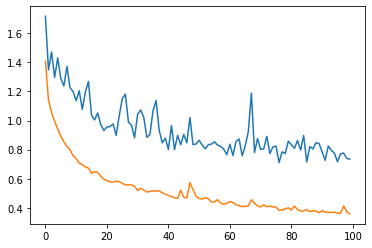

In [ ]:
train = pd.DataFrame(train_loss)
valid = pd.DataFrame(valid_loss)


plt.plot(valid)
plt.plot(train)

In [ ]:
# rolling mean across it 5 or 10 epochs will let you see the underlining trend. 
# pay attention to the bottom validation lost will help us see when we are hitting the bottom 

# numpy .percentile for the distrubition of the bulk of the pixels. 99th percentile is what great being uses!
# robust statistics - wiki it ! 
# winderwiser mean - this can also give 
# bias varience trade off : great being has spoken! 
# curriculum learning : its a bit of a deep dive- when neural nets are naive they need easy data to work with.
# ablation testing - remove parts of your pipeline

#losses.append([epoch, correct/len(train_dataset), loss.item()])
lossdf = pd.DataFrame(losses)
lossdf.columns = ['epoch', 'accuracy', 'negativeloss']

In [ ]:
## Saving the model 
name = 'Resnet50_mixdataThreshMIX_10_27_21'#'Resnet50_mixdataThresh_10_20_21' #'Resnet50_mixdataThreshMIX_10_20_21' 'Resnet50_mixdata_9_27_21'#'Resnet50_mixdata_9_24_21' #'Resnet50_mixdata_Threh_NT_9_13_21' #'Resnet50_mixdata_9_13_21' #'Resnet50_mixdata' #'Resnet18_mixdata'#'Resnet50_mixdata'  #  
torch.save(model.state_dict(), path+'/{}.pth'.format(name)) 

# saving the loss data
train = pd.DataFrame(train_loss)
valid = pd.DataFrame(valid_loss)
 
train.to_csv(os.getcwd()+'/'+'traindf_{}.csv'.format(name), sep = '\t' , index = True) 
valid.to_csv(os.getcwd()+'/'+'validdf_{}.csv'.format(name), sep = '\t' , index = True) 

In [ ]:
## loading in Model
name = 'Resnet50_mixdataThreshMIX_224x224' #'Resnet50_mixdataThresh_10_20_21'#'Resnet50_mixdataThresh_10_13_21' #'Resnet50_mixdataBinaryThresh_9_29_21' #'Resnet50_mixdataThresh_9_27_21' #Resnet50_mixdataMT_9_27_21' #'Resnet50_mixdata_9_13_21'  # 'Resnet50_mixdata_9_13_21'
model.load_state_dict(torch.load(os.getcwd()+'/{}.pth'.format(name), map_location={'cuda:0': 'cpu'})) # to load model with cpu
model.to(device) # will turn model for GPU or CPU depending on the device stated above
model.eval()

#loading in lossdf

#The loss from training converges quickly over ten epochs in this case.
test(model, device, criterion, test_loader)



tensor([[ 4.3000, -0.9541, -3.4079, -0.0515]], device='cuda:0',
       grad_fn=<AddmmBackward>)
Actual = Circular numb_0
Prediction Success


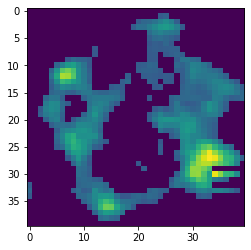

In [ ]:
# Get a batch of training data
inputs, masks = next(iter(dataloaders['val']))
print(model(inputs[0][0].view(-1,1, 40,40).to(device).float()))
# checking to see if the predictions match 
if masks[0] == 1:
    print('Actual = Senescent numb_{}'.format(masks[0]))
    with torch.no_grad():
      predic = torch.argmax(model(inputs[0][0].view(-1,1, 40,40).to(device).float()))
    if predic == masks[0]:
        print('Prediction Success')
    else:
        print('MODEL FAIL')
if masks[0] == 0:
    print('Actual = Circular numb_{}'.format(masks[0]))
    with torch.no_grad():
      predic = torch.argmax(model(inputs[0][0].view(-1,1, 40,40).to(device).float()))
    if predic == masks[0]:
        print('Prediction Success')
    else:
        print('MODEL FAIL')
if masks[0] == 2:
    print('Actual = cytoplasm numb_{}'.format(masks[0]))
    with torch.no_grad():
      predic = torch.argmax(model(inputs[0][0].view(-1,1, 40,40).to(device).float()))
    if predic == masks[0]:
        print('Prediction Success')
    else:
        print('MODEL FAIL')

if masks[0] == 3:
    print('Actual = nuclearnumb_{}'.format(masks[0]))
    with torch.no_grad():
      predic = torch.argmax(model(inputs[0][0].view(-1,1, 40,40).to(device).float()))
    if predic == masks[0]:
        print('Prediction Success')
    else:
        print('MODEL FAIL')
plt.imshow(inputs[0][0])

### Running Pipline and Model quickly
this is using images that are already cropped 40x40
Simply testing the model on the testing dataset, which the model never saw before. The output will be a confusion matrix

In [158]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(9, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")


    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.tight_layout()
    plt.savefig('Confusion_Matrix.pdf')
    plt.show()
     

In [140]:
datainfo ='mix_data' #'mix_data' #'mdm38_6_22_20'   #cox4_6_22_21'# 
path2 ='/mix_40x40_gfp'
## load the Dataframes for Testing and train
traindf = pd.read_csv(os.getcwd()+'/'+'train_dataset_{}.csv'.format(datainfo), sep = '\t', index_col=0) # index_col loads it in with the index shuffled as is 
testdf =pd.read_csv(os.getcwd()+'/'+'test_dataset_{}.csv'.format(datainfo), sep = '\t', index_col=0)
filedf =pd.read_csv(os.getcwd()+'/'+'all_dataset_{}.csv'.format(datainfo), sep = '\t', index_col=0)
rlsdf = pd.read_csv(os.getcwd()+'/'+ 'mdm38_6_22_20_daughter_cells.csv', sep = '\t', index_col=0) #'Mitochondria_COX4_daughter_cells.csv' #'mdm38_6_22_20_daughter_cells.csv', sep = '\t', index_col=0)
 

In [141]:
filedf = testdf

In [32]:
testdf  = testdf  .sort_values(['cell', 'pos', 'time']) # to sort the dataframe 

In [142]:
mdm38_set_nt2, d = loaddata(filedf ,path2, threshold = False ) # will load in the orginal data 
mdm38_set2, d = loaddata(filedf ,path2 ) # will load in the orginal data 

In [147]:
collectls =[]
trialls =[]
confusionmatrix = True
sizex = 224
sizey= 224
for row in range(filedf.shape[0]):
  cellname = filedf.iloc[row]['file'].split('-')[0]
  file = filedf.iloc[row]['file']
  time = filedf.iloc[row]['time']
  pos = filedf.iloc[row]['pos']
  cell = filedf.iloc[row]['cell']
  transform = transforms.ToTensor() # for transformation
  gfptensor = transform(mdm38_set2[row,:,:].astype(np.float32)) # turning numpy array to tensor 
  with torch.no_grad(): # supposed to speed it up
      phenotype = torch.argmax(model(gfptensor.view(-1,1, sizex,sizey).to(device)))  # determining the phenotype 

  if phenotype == 0:
    phenotype = 'Circular'
  elif phenotype ==1:
    phenotype = 'Other'
  elif phenotype ==2:
    phenotype = 'Cytoplasm'
  elif phenotype ==3:
    phenotype = 'Aggregate'
  elif phenotype ==4:
    phenotype = 'Fragmented'
  elif phenotype ==5:
    phenotype = 'Binary Aggregates'
  elif phenotype ==6:
    phenotype = 'Triple'
    
 

  with torch.no_grad(): # will speed it up
    probablity = model(gfptensor.view(-1,1, sizex,sizey).to(device)) # for RESNET 
      #probablity = (1-(1-(model(gfptensor.view(-1,1, 40,40)))))*100# probablity percentange 
  probablity = torch.nn.functional.softmax(probablity ).to('cpu').detach().numpy() # probablity.to('cpu').detach().numpy()
  probablity = (probablity/np.sum(np.abs(probablity)))*100


  #probablity = (probablity.detach().numpy())  # turn tensor into a numpy array for CNN 
  circularprop = probablity.item(0)
  senecentprop = probablity.item(1)
  cytoplasmprop = probablity.item(2)
  aggregateprop = probablity.item(3)
  fragprop = probablity.item(4)
  biaggreprop = probablity.item(5)
  tripleprop = probablity.item(6)


  collectls.append([cellname,cell, time, pos,row, phenotype,circularprop ,aggregateprop,senecentprop,cytoplasmprop,fragprop, biaggreprop,tripleprop, probablity, file ])
  if confusionmatrix is True:

    if 'circle_' in file:
        actualnumb = 0
        actualpheno='Circular'
    elif 'senecent_' in file:
        actualnumb = 1
        actualpheno='Other'
    elif 'cytoplasm_' in file:
        actualnumb= 2
        actualpheno='Cytoplasm'
    elif 'nuclear_' in file:
        actualnumb = 3
        actualpheno= 'Aggregate'
    elif 'fragmented_' in file:
        actualnumb = 4
        actualpheno='Fragmented'
    elif 'BinaryAggregate_' in file:
        actualnumb = 5
        actualpheno='Binary Aggregates'
    elif 'triple_' in file:
        actualnumb = 6
        actualpheno= 'Triple'
    prednumb = int( torch.argmax(model(gfptensor.view(-1,1, sizex,sizey).to(device))).to('cpu').detach().numpy())
    trialls.append([cellname,cell, time, pos,row,actualpheno, phenotype, actualnumb ,prednumb, circularprop/100 ,aggregateprop/100,senecentprop/100,cytoplasmprop/100,fragprop/100, biaggreprop/100,tripleprop /100, probablity, file ])



collectls = pd.DataFrame(collectls) 
collectls.columns = ['name', 'cell','time', 'pos','row', 'phenotype','circular_prop', 'aggregate_prop', 'senecent_prop', 'cytoplasm_prop', 'fragmented_prop', 'binary_prop', 'triple_prop', 'probablity', 'file']     
collectls = collectls.drop_duplicates(['name', 'time'])
collectls = collectls.set_index('name')

if confusionmatrix is True: 
  trialls = pd.DataFrame(trialls) 
  trialls.columns = ['name', 'cell','time', 'pos','row', 'actualpheno',  'predphenotype', 'actual_prop', 'predicted_prop','circular_prop', 'aggregate_prop', 'senecent_prop', 'cytoplasm_prop', 'fragmented', 'binary', 'triple', 'probablity', 'file']     
  trialls = trialls.drop_duplicates(['name', 'time'])
  trialls = trialls.set_index('name')

<ipython-input-147-edad86501b1c>:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probablity = torch.nn.functional.softmax(probablity ).to('cpu').detach().numpy() # probablity.to('cpu').detach().numpy()


In [148]:
if confusionmatrix is True:
  percentcorr = sum(trialls['actualpheno'] == trialls['predphenotype'])/trialls.shape[0] *100

  print( 'total files {}'.format(trialls.shape[0]), '\n',
        'Average Percent of data correct {}'.format(percentcorr), '\n')
  
  for pheno in trialls['actualpheno'].unique():
    x = trialls['actualpheno'] ==pheno
    shared = (trialls['actualpheno'] ==pheno) & (trialls['predphenotype'] ==pheno)
    notshared = (trialls['actualpheno'] !=pheno) & (trialls['predphenotype'] !=pheno)
    y = trialls['actualpheno'] != pheno
    print(pheno.capitalize() , 'percent correct {}'.format((sum(shared)/ sum(x))*100 ),  'percent NOT pheno {}'.format((sum(notshared)/ sum(y))*100 ))


total files 965 
 Average Percent of data correct 82.27979274611398 

Other percent correct 87.66233766233766 percent NOT pheno 97.78051787916154
Aggregate percent correct 88.73239436619718 percent NOT pheno 97.32685297691373
Triple percent correct 63.829787234042556 percent NOT pheno 98.30097087378641
Fragmented percent correct 84.50704225352112 percent NOT pheno 96.23329283110571
Circular percent correct 93.4959349593496 percent NOT pheno 92.87410926365796
Binary aggregates percent correct 63.49206349206349 percent NOT pheno 98.80810488676997
Cytoplasm percent correct 93.43065693430657 percent NOT pheno 98.06763285024155


<Figure size 432x288 with 0 Axes>

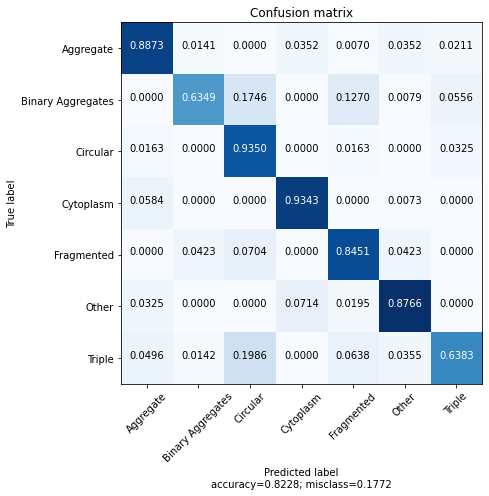

In [159]:
actual = trialls.sort_values('actualpheno')['actualpheno'].values
predict = trialls.sort_values('actualpheno')['predphenotype'].values

cm = confusion_matrix(actual, predict, labels = trialls.sort_values('actualpheno')['actualpheno'].unique())
plt.savefig('Confusion_Matrix.pdf')
plot_confusion_matrix(cm,
                          trialls.sort_values('actualpheno')['actualpheno'].unique(),
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True)
 

In [ ]:
 
# confusion matrix 7 classes 7 probablites with the actual phenotype
#7 x 7 matrix  row what it predicted and column what its supposed to predict. 
#could be a block structure
#will tell me if my labels are same

# if output is too high put through softmax to 0-1
# negative values means the net is expanding too much so the signal may be too high

In [ ]:
#Visually see Images labeled in Different Categories

In [ ]:
for row in trialls.loc[trialls['predphenotype'] == 'aggregate', 'row']:
  f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,10))
  ax1.imshow(mdm38_set2[row])
  ax1.set_title(trialls.iloc[row ]['actualpheno' ])  
  ax2.imshow(mdm38_set_nt2[row])
  plt.show()

In [ ]:
collectls['budding_sum'] = 0
try:
  rlsdf = rlsdf.set_index('position')
except:
  pass
for cellname in collectls.index:
  collectls.loc[cellname, 'budding_sum'] = rlsdf.loc[cellname,'budding_sum']

In [ ]:
ls = []
 
for col in collectls.index.unique():
    for pheno in sorted(collectls['phenotype'].unique()):
        numb = sum(collectls.loc[col, 'phenotype'] == pheno)
        budsum = rlsdf.loc[col, 'budding_sum']
        timebuds = rlsdf.loc[col, 'time_budding']
        ls.append({'position' :col, 'phenotype' : pheno,'number': numb })
phenocount = pd.DataFrame(ls)
#phenocount.columns = ['position', 'phenotype', 'number']
phenocount = phenocount.pivot(index = 'position', columns = 'phenotype')['number']
phenocount['budding_sum'] =0
phenocount['time_budding'] =0
phenocount.loc[phenocount.index, 'budding_sum'] = rlsdf.loc[phenocount.index, 'budding_sum'].values
phenocount.loc[phenocount.index, 'time_budding'] = rlsdf.loc[phenocount.index, 'time_budding'].values

In [ ]:
c = []
a = []
cy = []
s = []
f= []
b = []
t = []

for file in filedf['file']:
  if 'circle' in file:
    c.append(file)
  if 'nuclear' in file:
    a.append(file)
  if 'senecent' in file:
    s.append(file)
  if 'cytoplasm' in file:
    cy.append(file)
  if 'fragmented' in file:
    f.append(file)
  if 'Binary' in file:
    b.append(file)
  if 'triple' in file:
    t.append(file)
print('mix_mother data', '\n','circles {}'.format(len(c)), '\n', 'aggregate {}'.format(len(a)), '\n', 'senecent {}'.format(len(s)),'\n', 'cytoplasm {}'.format(len(cy)),  '\n',
      'fragmented {}'.format(len(f)) , '\n', 'binary {}'.format(len(b)),  '\n', 'triple {}'.format(len(t)))

mix_mother data 
 circles 123 
 aggregate 142 
 senecent 154 
 cytoplasm 137 
 fragmented 142 
 binary 126 
 triple 141


In [ ]:
phenotype
for file in collectls.loc[collectls['phenotype'] == 'circular', 'file']:
  if file not in c:
    f, (ax1,ax2) = plt.subplots(1,2, figsize = (10,10))
    img = skimage.io.imread(path1 + '/' +file)
    ax1.set_title(file)
    ax1.imshow(img)
    img2 = img.copy()
    maskgfp = img2 > (np.mean(img) +(np.std(img)*.2))
    img2[~maskgfp] = 0

    ax2.imshow(img2)
    plt.show()


In [ ]:
phenotype
for file in collectls.loc[collectls['phenotype'] == 'circular', 'file']:
  if file not in c:
    img = skimage.io.imread(path1 + '/' +file)
    plt.title(file)
    plt.imshow(img)
    plt.show()

## Ablation Test
I am ablating some of the input images to see if the classifer is learning the key features that I am interested in

In [37]:
test = skimage.io.imread(path1 +'/'+ filedf['file'][4])

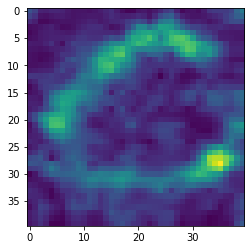

In [38]:
plt.imshow(test)

In [45]:
torch.argmax(model(convgfptensor.view(-1,1, 40,40).to(device)))

tensor(1, device='cuda:0')

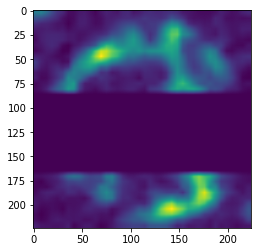

In [77]:
 
plt.imshow(cv2.resize(test1, (sizex, sizey)).astype(np.float32) )

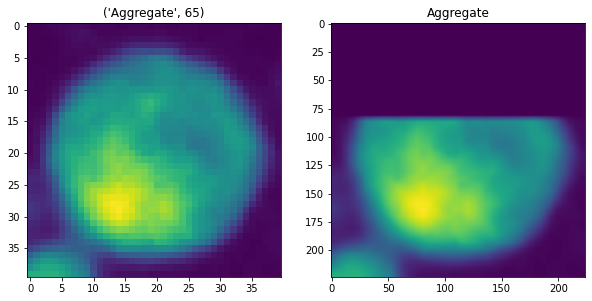

<Figure size 432x288 with 0 Axes>

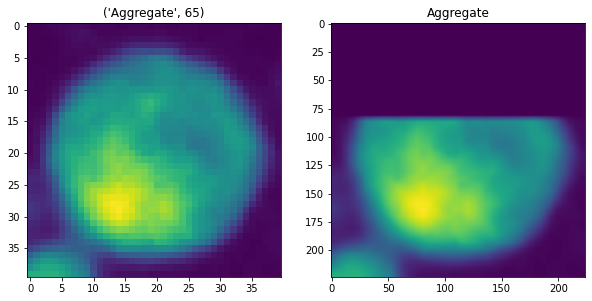

<Figure size 432x288 with 0 Axes>

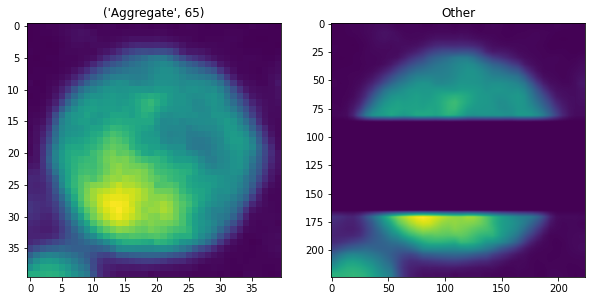

<Figure size 432x288 with 0 Axes>

In [107]:
l = []
convsize = 600
row = 65
sample = 1 # which of the batch samples to use 
file = filedf['file'][row]
test = skimage.io.imread(path1 +'/'+ file)
for num in range(0, len(test.ravel()), convsize):
     
    test = (test - np.min(test))/ (np.max(test) - np.min(test))
    #thresh = np.mean(test) +(np.std(test)*.2)
    #maskgfp = test >= thresh
    #test[~maskgfp] = 0 # just turn everything else to 0 but leave the high intesnity values the same 

    test1 =  test.copy()
    
    test1 = test1.ravel()
    if num == 0:
        test1[0:convsize] = 0
    else:
        test1[num-convsize:num] = 0
    test1 = test1.reshape(40,40)
    test1 =  cv2.resize(test1, (sizex, sizey)).astype(np.float32)
    test2 =  cv2.resize(test, (sizex, sizey)).astype(np.float32)
    with torch.no_grad(): # will speed it up
      transform = transforms.ToTensor() # for transformation
      gfptensor = transform(test2 .astype(np.float32)) # turning numpy array to tensor 
      convgfptensor = transform(test1 .astype(np.float32)) # turning numpy array to tensor 

      phenotype = torch.argmax(model(gfptensor.view(-1,1, sizex,sizey).to(device))).to('cpu').detach().numpy()   # determining the phenotype 
      convphenotype = torch.argmax(model(convgfptensor.view(-1,1,sizex,sizey).to(device))).to('cpu').detach().numpy()   # determining the phenotype 
 
      if phenotype == 0:
        phenotype = 'Circular'
      elif phenotype ==1:
        phenotype = 'Other'
      elif phenotype ==2:
        phenotype = 'Cytoplasm'
      elif phenotype ==3:
        phenotype= 'Aggregate'
      elif phenotype ==4:
        phenotype= 'Fragmented'
      elif phenotype ==5:
        phenotype= 'Binary Aggregate'
      elif phenotype ==6:
        phenotype= 'Triple'

      if convphenotype == 0:
        convphenotype = 'Circular'
      elif convphenotype ==1:
        convphenotype = 'Other'
      elif convphenotype ==2:
        convphenotype = 'Cytoplasm'
      elif convphenotype ==3:
        convphenotype= 'Aggregate'
      elif convphenotype ==4:
        convphenotype= 'Fragmented'
      elif convphenotype ==5:
        convphenotype= 'Binary Aggregate'
      elif convphenotype ==6:
        convphenotype= 'Triple'
 
    with torch.no_grad(): # will speed it up
      probablity = model(gfptensor.view(-1,1, sizex,sizey).to(device)) # for RESNET

    probablity = probablity.to('cpu').detach().numpy()
    probablity = (probablity/np.sum(probablity))*100 
 
 
    f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,10))
    ax1.imshow(test)
    ax1.set_title((phenotype, row))
 
  
    ax2.set_title(convphenotype)
    ax2.imshow(test1)

    plt.show()
    plt.tight_layout()

In [ ]:
#https://medium.com/the-owl/extracting-features-from-an-intermediate-layer-of-a-pretrained-model-in-pytorch-c00589bda32b
children_counter = 0
for n,c in model.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1

Children Counter:  0  Layer Name:  conv1
Children Counter:  1  Layer Name:  bn1
Children Counter:  2  Layer Name:  layer1
Children Counter:  3  Layer Name:  layer2
Children Counter:  4  Layer Name:  layer3
Children Counter:  5  Layer Name:  layer4
Children Counter:  6  Layer Name:  averagePool
Children Counter:  7  Layer Name:  fc
